In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import time
from statistics import mean, stdev
from pytrends.request import TrendReq
from urllib3.exceptions import MaxRetryError

from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings

C:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


# GDP data reading and cleaning

In [3]:
gdp_path = '../../data/expenditure/expenditure_gdp.csv'
gdp = pd.read_csv(gdp_path)
gdp['REF_DATE'] = pd.to_datetime(gdp['REF_DATE'])
gdp.head(2)

C:\Users\sidhu\AppData\Local\Temp/ipykernel_21776/2999133702.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  gdp = pd.read_csv(gdp_path)


,REF_DATE,GEO,DGUID,Prices,Seasonal adjustment,Estimates,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1961-01-01,Canada,2016A000011124,Chained (2012) dollars,Seasonally adjusted at annual rates,Final consumption expenditure,Dollars,81,millions,6,v62305723,1.1.1.1,273818.0,NaN,NaN,NaN,0
1,1961-01-01,Canada,2016A000011124,Chained (2012) dollars,Seasonally adjusted at annual rates,Household final consumption expenditure,Dollars,81,millions,6,v62305724,1.1.1.2,182300.0,NaN,NaN,NaN,0


### Extracted only required columns and rows

In [4]:
# filter data
gdp_subset = gdp[(gdp['REF_DATE'] >= '2004-01-01') &
                (gdp['Prices'] == 'Chained (2012) dollars') & 
                (gdp['Estimates'] == 'Gross domestic product at market prices') &
                 (gdp['UOM'] == 'Dollars')]
gdpts = gdp_subset[['REF_DATE', 'VALUE']]

# rename columns
gdpts = gdpts.rename(columns = {'REF_DATE': 'Date', 'VALUE': 'GDP'})
gdpts.index = gdpts['Date']
gdpts = gdpts.drop(columns = ['Date'])

In [78]:
gdp_original = gdpts.copy()
gdpts.tail()

,GDP,GDP_GrowthRate
Date,,
2020-10-01,2058185.0,0.021924
2021-01-01,2082323.0,0.011728
2021-04-01,2063554.0,-0.009013
2021-07-01,2091318.0,0.013454
2021-10-01,2125350.0,0.016273


### Time series of GDP

In [6]:
def plot_df(y, title="", xlabel='Date', ylabel='Value', dpi=100, width=16, height=5):
    y.index = pd.to_datetime(y.index)
    fig = plt.figure(figsize=(width, height), dpi=dpi)
    plt.plot(y, marker='o', markersize=4)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.close()
    return fig


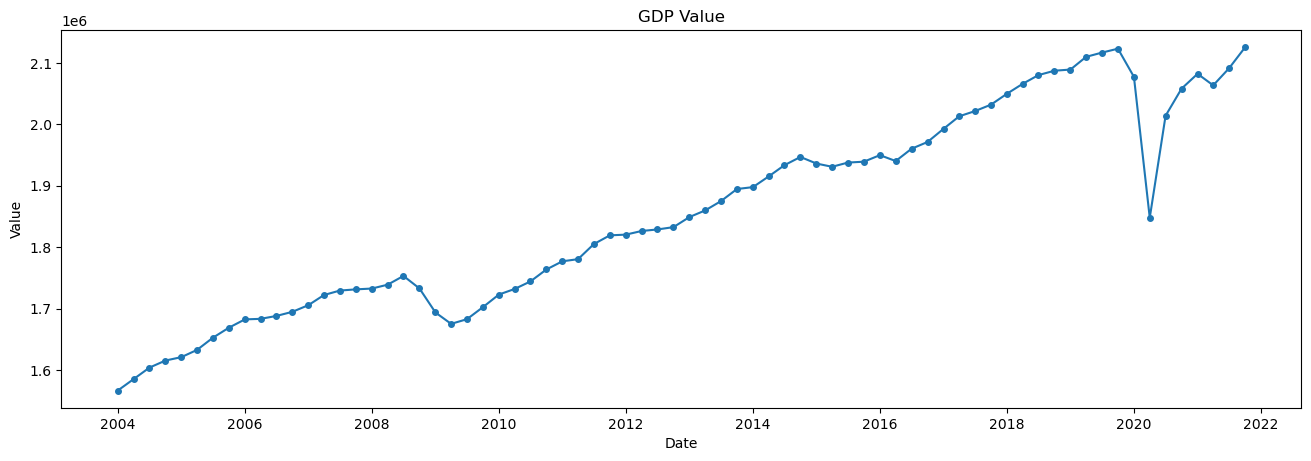

In [7]:
fig = plot_df(gdpts['GDP'], title="GDP Value")
fig

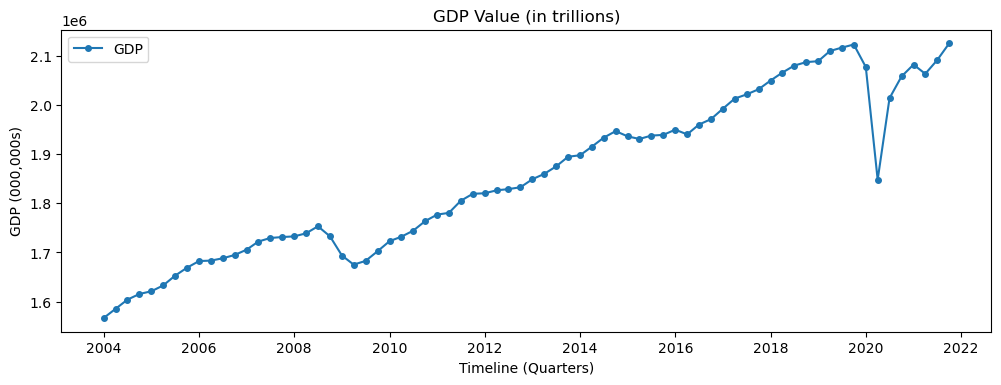

In [8]:
#### GDP Plot for presentation 
plot_data = gdpts['GDP']

plot_data.index = pd.to_datetime(plot_data.index)
fig = plt.figure(figsize=(12, 4), dpi=100)
plt.plot(plot_data, marker='o', markersize=4, label="GDP")
plt.gca().set(title="GDP Value (in trillions)", xlabel="Timeline (Quarters)", ylabel="GDP (000,000s)")
plt.xticks()
plt.legend()
#plt.savefig('GDP_timeseries.png')
plt.show()

### Growth rate of GDP

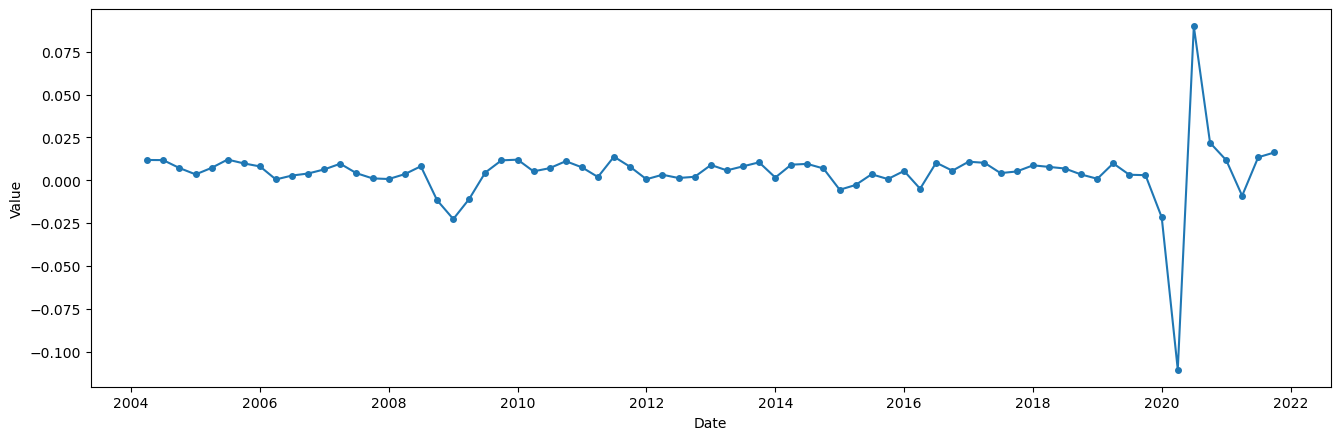

In [9]:
gdpts['GDP_GrowthRate'] = gdpts['GDP'].pct_change()
gdpts = gdpts.dropna()

plot_df(gdpts['GDP_GrowthRate'])

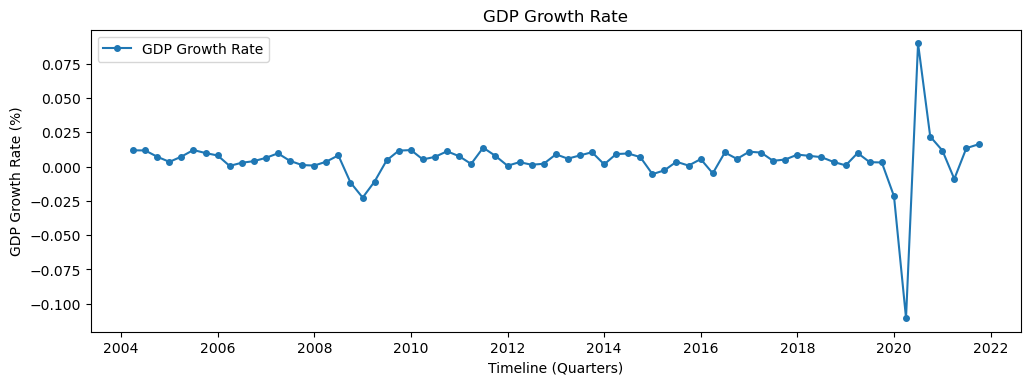

In [10]:
#### GDP Growth Rate Plot for presentation 
plot_data = gdpts['GDP_GrowthRate']

plot_data.index = pd.to_datetime(plot_data.index)
fig = plt.figure(figsize=(12, 4), dpi=100)
plt.plot(plot_data, marker='o', markersize=4, label="GDP Growth Rate")
plt.gca().set(title="GDP Growth Rate", xlabel="Timeline (Quarters)", ylabel="GDP Growth Rate (%)")
plt.xticks()
plt.legend()
#plt.savefig('GDP_timeseries.png')
plt.show()

### Check stationarity

In [11]:
# source link: https://www.statsmodels.org/devel/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

def adf_test(timeseries):
    #print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    #print(dfoutput)
    if dftest[1] < 0.05:
        return f"Series is stationary"
    else:
        return f"Series is not stationary"


def kpss_test(timeseries):
    #print("Results of KPSS Test:")
    warnings.filterwarnings("ignore")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    #print(kpss_output)
    if kpsstest[1] > 0.05:
        return f"Series is stationary"
    else:
        return f"Series is not stationary"

def check_stationarity(dataframe):
    for i in range(0,dataframe.shape[1]):
        timeseries = dataframe.iloc[:,i]
        adf_result = adf_test(timeseries)
        kpss_result = kpss_test(timeseries)
        if (adf_result == "Series is stationary") and (kpss_result == "Series is stationary"):
            pass
        elif (adf_result == "Series is not stationary") and (kpss_result == "Series is not stationary"):
            print(f"Series {dataframe.columns[i]} is not stationary")
        elif (adf_result == "Series is stationary") and (kpss_result == "Series is not stationary"):
            print(f"Series {dataframe.columns[i]} is not stationary, differencing can be used to make it stationary")
        elif (adf_result == "Series is not stationary") and (kpss_result == "Series is stationary"):
            print(f"Series {dataframe.columns[i]} is trend stationary, trend needs to be removed")
    print("All other series are stationary")

In [12]:
adf_test(gdpts['GDP_GrowthRate'])


'Series is stationary'

In [13]:
kpss_test(gdpts['GDP_GrowthRate'])

'Series is stationary'

# Get predictors from Google Trends

In [14]:
# get caegories and keywords from csv file
key_path = '../../data/keywords_data/GDP.csv'
key_data = pd.read_csv(key_path)
cat_lst = key_data['CatNo'].unique()                    # list of categories
keywords_lst = key_data['Keywords'].dropna()   # list of selected keywords
keyCat_lst = key_data['keywordCatNo'].astype('Int64').dropna()   # list of categories corresponding to keywords

#### function to get trends using keyword/category

In [15]:
pytrends = TrendReq(hl='en-US', backoff_factor=0.1, timeout=(10,25))

# function to get google trend time series of respective


def get_trends(keyword=[''], category='0', related_queries=0, related_topics=0):
    """ function to get the google trend for desired keyword and category"""
    kw_list = keyword
    cat = category
    timeframe = '2004-01-01 2022-04-01'
    geo = 'CA'
    gprop = ''

    try:
        pytrends.build_payload(kw_list, cat, timeframe, geo, gprop)
        # get time series
        data = pytrends.interest_over_time()
    except:
        print(f"Category {cat} does not exist or keyword {kw_list[0]} has no time series")
        return [''], [''], ['']

    # get related queries
    try:
        if related_queries > 0:
            queries = pytrends.related_queries()
            if len(kw_list) == 0:
                queries_lst = list(queries['']['top']['query'].values[0:related_queries])
            else:
                queries_lst = list(queries[kw_list[0]]['top']['query'].values[0:related_queries])
        else:
            queries_lst = ['']
    except:
        queries_lst = ['']

    # get related topics
    try:
        if related_topics > 0:
            topics = pytrends.related_topics()
            if len(kw_list) == 0:
                topics_lst = list(topics['']['top']['topic_title'].values[0:related_topics])
            else:
                topics_lst = list(topics[kw_list[0]]['top']['topic_title'].values[0:related_topics])
        else:
            topics_lst = ['']
    except:
        topics_lst = ['']
    return data, queries_lst, topics_lst

#### function to get trends using keyword and respective category from a dictionary

In [16]:
# get timeseries dataframe of related queries and topics (top 2) of different selected categories
def get_trends_for_dict(dict, no_related_words):
    i = 0
    for key, value in dict.items():
        if no_related_words > len(value):
            print("Number of related words should not exceed {len(value)}.")
        else:
            category = key
            temp_lst = value[0:no_related_words]  # how may related words we want data for
            kw_lst = list(set(temp_lst))                # removes the repeated keywords
            for keyword in kw_lst:
                data, _, _ = get_trends(keyword=[keyword], category=category)

                # Code to append data for different keywords in data frame
                colname = category+"_"+keyword
                if i == 0:
                    data.rename(columns={keyword: colname}, inplace=True)
                    df = data.drop(columns=['isPartial'])
                else:
                    data.rename(columns={keyword: colname}, inplace=True)
                    data = data.drop(columns=['isPartial'])
                    df = df.join(data)
                i = i+1
                time.sleep(5)
    return df

In [17]:
# Read data from dictionaries
file1 = open('gdp_cat_queries_dict.json')
file2 = open('gdp_cat_topics_dict.json')

cat_queries_dict = json.load(file1)
cat_topics_dict = json.load(file2)

In [15]:
#get_trends_for_dict(temp, no_related_words=1)

In [15]:
#keywordsts.to_csv('gdp_keywords_ts_1705.csv.csv')

In [19]:
relatedQ_df = pd.read_csv('data_fo_related_queries.csv', index_col=0)

In [17]:
df2 = get_trends_for_dict(cat_topics_dict, no_related_words=1)
df2.head()

,569_Cineplex Entertainment,23_Dance,47_Car,815_Canada,170_Driving,249_Health,71_Recipe,276_Restaurant,634_Clinic,250_Hospital,...,1162_Canada Revenue Agency,53_GoDaddy,342_Enterprise resource planning,1159_Salary,1214_Truck,670_Fertilizer,12_Canada,566_Textile,672_Adhesive,673_Color
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,0,75,83,74,53,67,28,36,14,65,...,0,4,0,22,45,24,53,60,10,50
2004-02-01,0,71,84,80,44,54,26,35,11,76,...,0,5,100,29,53,31,51,100,41,76
2004-03-01,0,82,87,89,46,62,24,34,10,78,...,0,1,0,23,41,61,51,48,13,31
2004-04-01,19,79,95,85,52,51,23,31,12,79,...,0,3,0,40,53,31,51,71,61,100
2004-05-01,0,76,100,92,49,76,24,33,12,73,...,0,4,0,27,58,27,49,43,45,0


In [22]:
#df2.to_csv('data_of_related_topics.csv')

In [20]:
relatedT_df = pd.read_csv('data_of_related_topics.csv', index_col=0)

### Store data

In [534]:
keywordsts.to_csv('gdp_keywords_ts.csv')
categoryts.to_csv('gdp_category_ts.csv')

#store Queries and topics
with open('gdp_cat_queries_dict.json', 'w') as fp:
    json.dump(cat_queries_dict, fp,  indent=4)

with open('gdp_cat_topics_dict.json', 'w') as fp:
    json.dump(cat_topics_dict, fp,  indent=4)
    
with open('gdp_keywords_queries_dict.json', 'w') as fp:
    json.dump(keywords_queries_dict, fp,  indent=4)

with open('gdp_keywords_topics_dict.json', 'w') as fp:
    json.dump(keywords_topics_dict, fp,  indent=4)

In [18]:
keywordsts.to_csv('gdp_keywords_ts_1205.csv')
categoryts.to_csv('gdp_category_ts_1205.csv')

### Read data

In [21]:
keywordsts = pd.read_csv('gdp_keywords_ts.csv', index_col=0)
categoryts = pd.read_csv('gdp_category_ts.csv', index_col=0)

# data on 12-05-2022
categoryts_today = pd.read_csv('gdp_category_ts_1205.csv', index_col=0)

### Check for two samples at different time

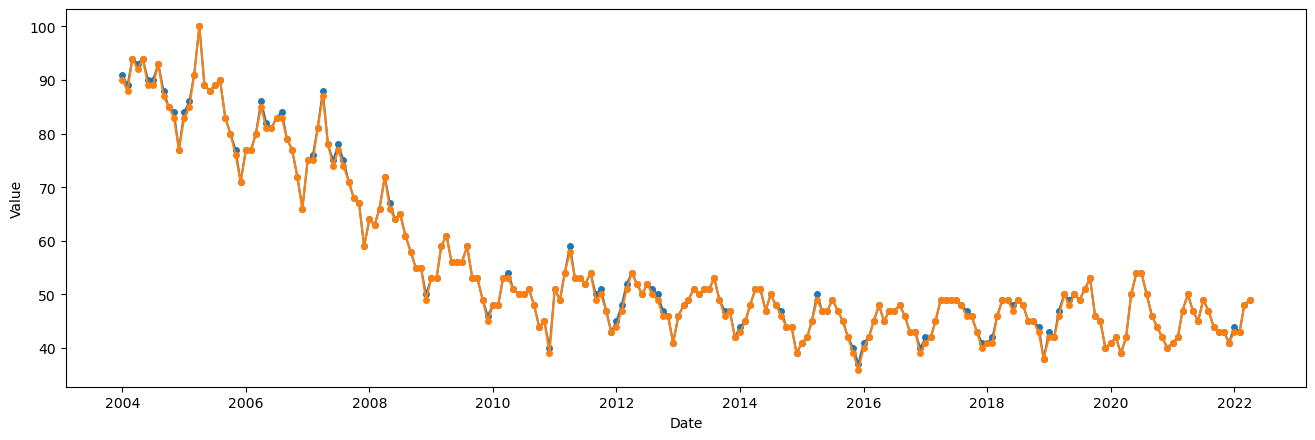

In [22]:
sample_check = pd.DataFrame({'A':categoryts[categoryts.columns[2:3]]['47'], 'B':categoryts_today[categoryts_today.columns[2:3]]['47']})
sample_check.index = pd.to_datetime(sample_check.index)
plot_df(sample_check[sample_check.columns[0:2]])

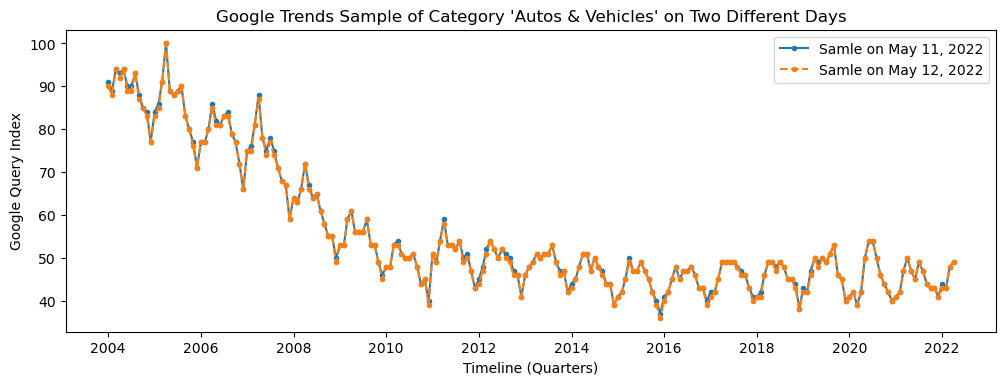

In [23]:
#### Two samples at different time 
plot_data = sample_check

plot_data.index = pd.to_datetime(plot_data.index)
fig = plt.figure(figsize=(12, 4), dpi=100)
plt.plot(plot_data.iloc[:,0], marker='o', markersize=3, label="Samle on May 11, 2022")
plt.plot(plot_data.iloc[:,1], marker='o', markersize=3, label="Samle on May 12, 2022", linestyle="--")
plt.gca().set(title="Google Trends Sample of Category 'Autos & Vehicles' on Two Different Days", 
              xlabel="Timeline (Quarters)", ylabel="Google Query Index")
plt.xticks()
plt.legend()
#plt.savefig('two_samples.png')
plt.show()

# Remove long-term bias (downward trend)

### Functions to extract long term trend and remove long term bias

In [24]:
# function to get long term trend
# source link: statsmodels.org/dev/generated/statsmodels.tsa.filters.hp_filter.hpfilter.html

def get_long_term_trend(dataframe, freq='M'):
    dataframe = np.log(dataframe)
    long_term_trend_data = dataframe.copy()
    if freq == 'Q':
        lamb = 1600
    elif freq == 'M':
        lamb = 1600*3**4
    for column_name in dataframe.columns:
        cycle, trend = sm.tsa.filters.hpfilter(dataframe[column_name], lamb)
        long_term_trend_data[column_name] = trend
    return long_term_trend_data


def remove_downward_trend_bias(dataframe, gdp_categoryts_df, freq = 'M'):
    """pass dataframe to remove bias"""
    trend_data = get_long_term_trend(gdp_categoryts_df, freq)
    log_category = np.log(dataframe)
    log_category.replace([np.inf, -np.inf], 0, inplace=True)
    avg_logcategory = log_category.mean()
    pca = PCA(n_components=1)
    pca.fit(trend_data)
    component = pd.DataFrame(pca.fit_transform(trend_data))

    # rescale component
    # transformation source link: https://stats.stackexchange.com/questions/46429/transform-data-to-desired-mean-and-standard-deviation
    rescaled_component = avg_logcategory.mean() + (component - component.mean())*(avg_logcategory.std()/component.std())

    # remove long term bias
    transformed_data = log_category - rescaled_component.values
    transformed_data.index = pd.to_datetime(transformed_data.index)

    return transformed_data

In [25]:
transformed_data = remove_downward_trend_bias(categoryts, categoryts)

In [26]:
all_keywords_df = keywordsts.join(relatedQ_df)
all_keywords_df.index = pd.to_datetime(all_keywords_df.index)
all_keywords_df.head()

,Economic crisis,Crisis,Recession,Financial crisis,Krach,Unemployment,Unemployment benefits,Student loan,Loan,Interest,...,12_acces d,12_canada post,566_fabric,566_fabric fabric,672_epoxy,672_glue,673_couleurs,673_couleur,49_covid,49_manufacturing
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,0,27,0,0,0,27,25,43,55,44,...,7,22,34,35,13,10,63,20,0,83
2004-02-01,0,0,0,0,36,23,5,53,46,46,...,6,21,41,41,19,5,65,9,0,100
2004-03-01,0,0,0,0,44,20,32,34,42,45,...,7,19,59,59,23,12,62,36,0,58
2004-04-01,0,27,50,100,0,22,10,43,55,56,...,7,19,43,43,29,12,56,23,0,80
2004-05-01,0,0,45,0,0,17,14,41,50,49,...,9,19,35,35,16,11,44,31,0,73


In [27]:
categoryts.head()

,569,23,47,815,170,249,71,276,634,250,...,53,342,1159,1214,670,12,566,672,673,49
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,74,90,91,94,89,86,76,57,60,90,...,100,90,95,77,68,100,88,74,91,88
2004-02-01,70,85,89,93,88,87,72,58,52,98,...,96,100,95,91,77,99,96,79,82,100
2004-03-01,74,82,94,98,87,89,73,61,53,100,...,99,98,99,94,100,95,100,82,100,97
2004-04-01,72,82,93,96,89,83,70,55,54,94,...,89,92,89,98,96,94,87,77,81,89
2004-05-01,74,81,94,96,97,92,66,53,49,94,...,89,90,84,90,86,88,93,76,64,80


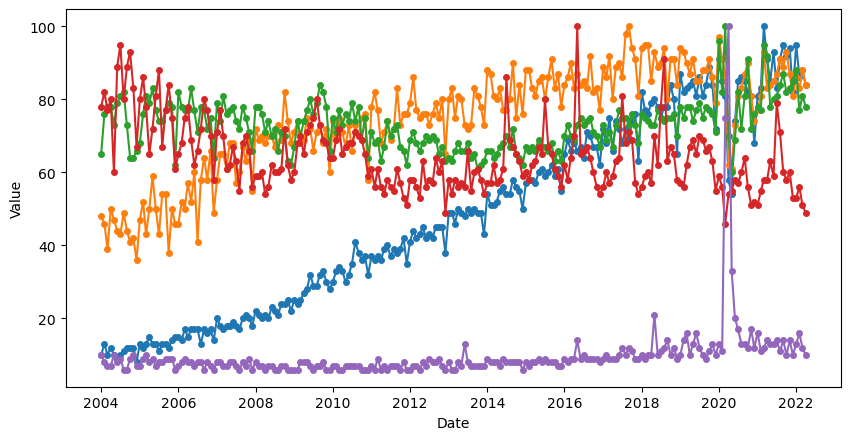

In [28]:
plot_df(all_keywords_df[all_keywords_df.columns[40:45]], width=10)

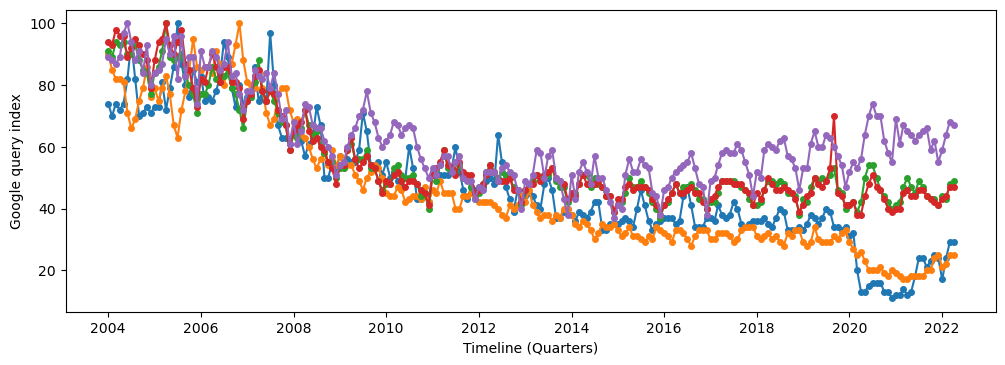

In [29]:
plot_df(categoryts[categoryts.columns[0:5]], width=12, height=4, ylabel="Google query index", xlabel="Timeline (Quarters)")

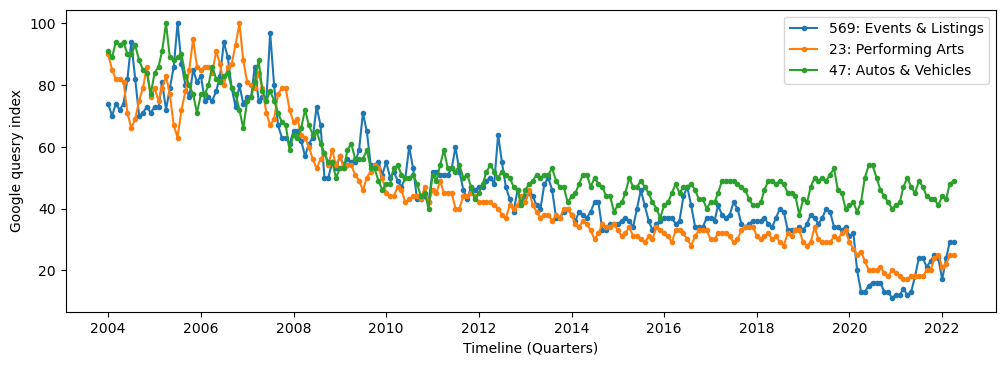

In [30]:
#### category series
plot_data = categoryts[categoryts.columns[0:3]]

plot_data.index = pd.to_datetime(plot_data.index)
fig2 = plt.figure(figsize=(12, 4), dpi=100)
plt.plot(plot_data.iloc[:,0], marker='o', markersize=3, label=plot_data.columns[0]+': Events & Listings')
plt.plot(plot_data.iloc[:,1], marker='o', markersize=3, label=plot_data.columns[1]+': Performing Arts')
plt.plot(plot_data.iloc[:,2], marker='o', markersize=3, label=plot_data.columns[2]+': Autos & Vehicles')
plt.gca().set(title="",
              xlabel="Timeline (Quarters)", ylabel="Google quesry index")
plt.xticks()
plt.legend()
plt.savefig('catgory_ts.png')
plt.show()

In [31]:
plot_data

,569,23,47
date,,,
2004-01-01,74,90,91
2004-02-01,70,85,89
2004-03-01,74,82,94
2004-04-01,72,82,93
2004-05-01,74,81,94
...,...,...,...
2021-12-01,24,25,41
2022-01-01,17,21,44
2022-02-01,24,22,43


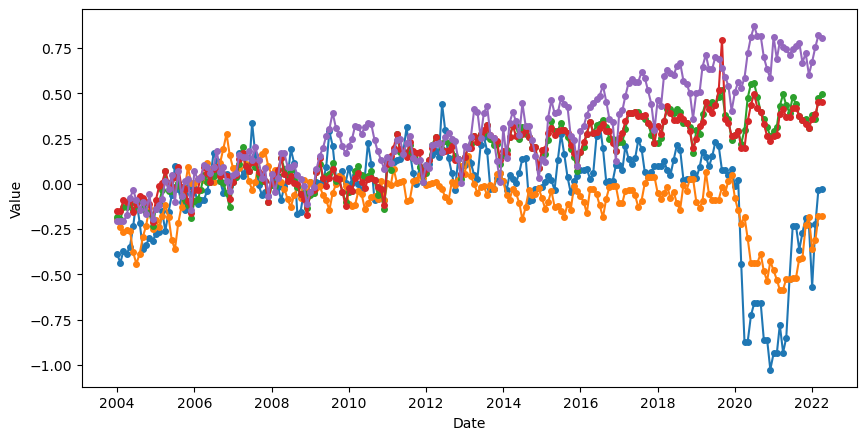

In [32]:
plot_df(transformed_data[transformed_data.columns[0:5]], width=10)

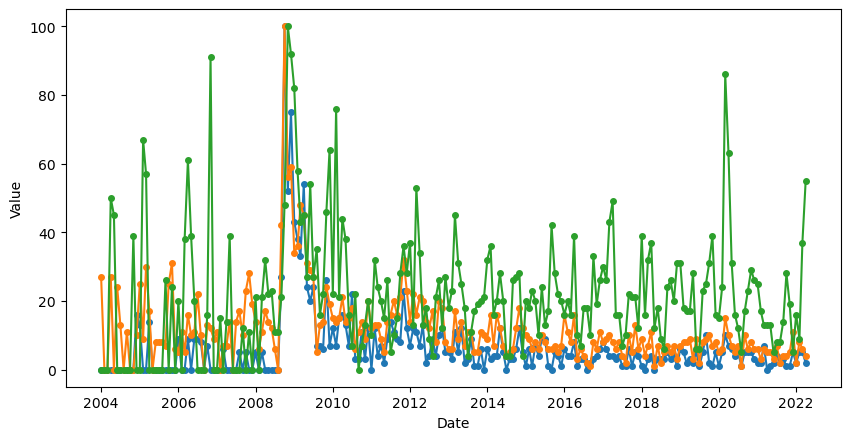

In [33]:
keywordsts.index = pd.to_datetime(keywordsts.index)
plot_df(keywordsts[keywordsts.columns[0:3]], width=10)

# Make GDP data quarterly

In [34]:
def get_gdp_data_quarterly(dataframe, match='0'):
    """ provides quarterly data of gdp predictors when monthly data is passed 
    input arguments: 
    dataframe: monthly data of google trends
    match: can take values '0', '-1', '-2', '-01', '-12', '-02', '-012'
           if match = 0 then data of months 1, 4, 7, 10 is returned that is same month when GDP is published
           if match = -1 then data (Google Trends) of one previous month 12, 3, 6, 9 are returned 
           if match = -2 then data (Google Trends) of one previous month 11, 2, 5, 8 are returned
           if match = -01 then data of same and previous month data is returned
           if match = -12 then data of two previous months is returned
           if match = -012 then data of all three months is returned"""
    if match not in ['0', '-1', '-2', '-01', '-12', '-012', '-02']:
        raise ValueError("Incorrect match value is passed !!")

    try:
        dataframe.index = pd.to_datetime(dataframe.index)

        same_month_data = dataframe[(dataframe.index.month == 4) |
                                    (dataframe.index.month == 7) |
                                    (dataframe.index.month == 10) |
                                    (dataframe.index.month == 1)]

        one_month_back_data = dataframe[(dataframe.index.month == 3) |
                                        (dataframe.index.month == 6) |
                                        (dataframe.index.month == 9) |
                                        (dataframe.index.month == 12)]
        one_month_back_data.index = one_month_back_data.index + pd.DateOffset(months=1)

        two_months_back_data = dataframe[(dataframe.index.month == 2) |
                                        (dataframe.index.month == 5) |
                                        (dataframe.index.month == 8) |
                                        (dataframe.index.month == 11)]
        two_months_back_data.index = two_months_back_data.index + pd.DateOffset(months=2)

        if str(match) == '0':
            return same_month_data
        if str(match) == '-1':
            return one_month_back_data
        if str(match) == '-2':
            return two_months_back_data
        if str(match) == '-01':
            return pd.merge(same_month_data, one_month_back_data, left_index=True, right_index=True)
        if str(match) == '-12':
            return pd.merge(one_month_back_data, two_months_back_data, left_index=True, right_index=True)
        if str(match) == '-012':
            temp = pd.merge(same_month_data, one_month_back_data, left_index=True, right_index=True)
            return pd.merge(temp, two_months_back_data, left_index=True, right_index=True)
        if str(match) == '-02':
            return pd.merge(same_month_data, two_months_back_data, left_index=True, right_index=True)
    except:
        print("Incorrect dataframe is passed !!")

In [35]:
Qcatgory_df = get_gdp_data_quarterly(categoryts, match='0')
Qallkeywords_df = get_gdp_data_quarterly(all_keywords_df, match='0')

In [36]:
Qcatgory_df.head()

,569,23,47,815,170,249,71,276,634,250,...,53,342,1159,1214,670,12,566,672,673,49
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,74,90,91,94,89,86,76,57,60,90,...,100,90,95,77,68,100,88,74,91,88
2004-04-01,72,82,93,96,89,83,70,55,54,94,...,89,92,89,98,96,94,87,77,81,89
2004-07-01,94,66,90,92,94,86,65,53,57,89,...,89,87,77,80,71,81,74,80,59,74
2004-10-01,71,79,85,90,84,81,76,54,57,89,...,79,88,86,77,79,89,92,80,89,92
2005-01-01,73,79,84,88,84,90,75,63,65,93,...,86,86,92,79,70,89,91,74,79,80


In [37]:
Qallkeywords_df.head(2)

,Economic crisis,Crisis,Recession,Financial crisis,Krach,Unemployment,Unemployment benefits,Student loan,Loan,Interest,...,12_acces d,12_canada post,566_fabric,566_fabric fabric,672_epoxy,672_glue,673_couleurs,673_couleur,49_covid,49_manufacturing
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,0,27,0,0,0,27,25,43,55,44,...,7,22,34,35,13,10,63,20,0,83
2004-04-01,0,27,50,100,0,22,10,43,55,56,...,7,19,43,43,29,12,56,23,0,80


In [38]:
gdpts.head(2)

,GDP,GDP_GrowthRate
Date,,
2004-04-01,1585347.0,0.011878
2004-07-01,1604061.0,0.011804


# Make series stationary

In [39]:
# function to normalize data

def normalize(dataframe):
    """ function to normalize dataframe"""
    data = dataframe.copy()
    scaler = StandardScaler()
    scaler.fit(dataframe)
    scaled_df = pd.DataFrame(scaler.transform(dataframe))
    scaled_df.index = data.index
    scaled_df.columns = data.columns
    return scaled_df


# function to get first difference (detrending)
def detrend(dataframe):
    return dataframe.diff().dropna()


# funtion to remove seasonality
def remove_seasonality(dataframe):
    data = dataframe.copy()
    # monthly mean
    mean_data = dataframe.groupby(dataframe.index.month).mean()
    for i, d in enumerate(data.index):
        data.iloc[i, :] = mean_data.loc[d.month]
    removed_seaonality_data = dataframe - data
    return removed_seaonality_data


# funtion to remove volatility
def remove_volatility(dataframe):
    data = dataframe.copy()
    # monthly mean
    std_data = dataframe.groupby(dataframe.index.year).std()
    for i, d in enumerate(data.index):
        data.iloc[i, :] = std_data.loc[d.year]
    removed_vol_data = dataframe - data
    return removed_vol_data

In [40]:
# selection of predictors frequency based
def predictor_selection(dataframe, year="2005-01-01"):
    temp_data = dataframe.copy()
    q_index = dataframe[(dataframe.index > year)].max()
    for i, qidx in enumerate(q_index):
        if qidx == 100:
            continue
        else:
            temp_data = temp_data.drop(columns=[q_index.index[i]])
    return temp_data



from scipy.stats import pearsonr
# selection of variables correlation based
def select_variables_with_correlation(response_gdpts, predictors_dataframe, req_corr=0.6):
    """ dataframe is 'categoryts' here"""
    predictors_dataframe.index = pd.to_datetime(predictors_dataframe.index)
    cols = list()
    data = pd.merge(response_gdpts, predictors_dataframe, left_index=True, right_index=True)

    for i in range(0, data.iloc[:, 2:].shape[1]):
        corr, _ = pearsonr(data['GDP'], data.iloc[:, i+2])
        if abs(corr) > req_corr:
            cols.append(data.columns[i+2])
    return predictors_dataframe[cols]

In [41]:
# make data stationary
scaled_Qcategory = normalize(Qcatgory_df)
scaled_Qkeywords = normalize(Qallkeywords_df)

diff_Qcategory = detrend(detrend(scaled_Qcategory))
diff_Qkeywords = detrend(detrend(scaled_Qkeywords))

final_category_df = remove_seasonality(diff_Qcategory)
final_keywords_df = diff_Qkeywords

In [42]:
# make data stationary after removing bias
Qcategory_rm_bias = remove_downward_trend_bias(Qcatgory_df, Qcatgory_df, freq='Q')
scaled_category_rm_bias = normalize(Qcategory_rm_bias)
firstdiff_category_rm_bias = detrend(detrend(scaled_category_rm_bias))    # double diff
final_category_df_rm_bias = remove_seasonality(firstdiff_category_rm_bias)

In [43]:
# Select predictors
# select predictors out of all the predictors
#selected_vars = predictor_selection(categoryts, year="2007-01-01")
less_predictors = select_variables_with_correlation(gdpts, categoryts)
temp_cat = get_gdp_data_quarterly(less_predictors, match='0')
temp_cat.shape

(74, 92)

In [44]:
tempcat = remove_seasonality(detrend(normalize(temp_cat)))
print(tempcat.shape)

(73, 92)


In [45]:
#check_stationarity(tempcat)

### Plot time series for stationarity check

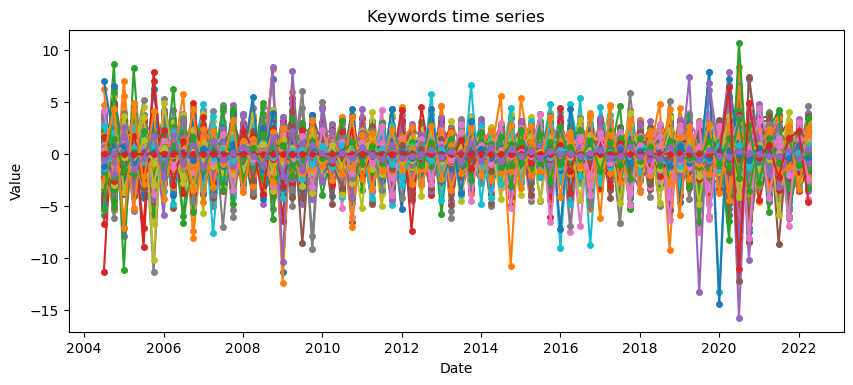

In [46]:
plot_df(final_category_df[final_category_df.columns[0:len(final_category_df.columns)]], 
        title="Categories time series", width=10, height=4)

plot_df(final_category_df_rm_bias[final_category_df_rm_bias.columns[0:len(final_category_df_rm_bias.columns)]], 
        title="Categories time series after removing downward bias",
        width=10, height=4)

plot_df(final_keywords_df[final_keywords_df.columns[0:len(final_keywords_df.columns)]],
        title="Keywords time series",
       width=10, height=4)

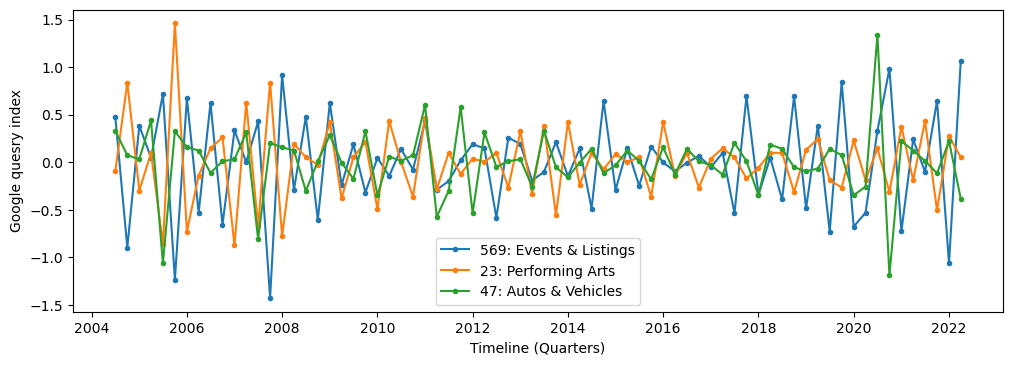

In [47]:
#### category series
plot_data = final_category_df[final_category_df.columns[0:3]]

plot_data.index = pd.to_datetime(plot_data.index)
fig2 = plt.figure(figsize=(12, 4), dpi=100)
plt.plot(plot_data.iloc[:,0], marker='o', markersize=3, label=plot_data.columns[0]+': Events & Listings')
plt.plot(plot_data.iloc[:,1], marker='o', markersize=3, label=plot_data.columns[1]+': Performing Arts')
plt.plot(plot_data.iloc[:,2], marker='o', markersize=3, label=plot_data.columns[2]+': Autos & Vehicles')
plt.gca().set(title="",
              xlabel="Timeline (Quarters)", ylabel="Google quesry index")
plt.xticks()
plt.legend()
plt.savefig('catgory_ts_stationary.png')
plt.show()

# Model fitting
## 1. ARIMA and DFM

### Train test split

In [48]:
# make one dataframe of the passed predictors
def make_predictors_df(*arg):
    "joins the predictors dataframes"
    if len(arg) > 1:
        for i in range(0, len(arg)-1):
            if i == 0:
                arg[i].index = pd.to_datetime(arg[i].index)
                arg[i+1].index = pd.to_datetime(arg[i+1].index)
                predictors_df = pd.merge(arg[i], arg[i+1], left_index=True, right_index=True)
            else:
                predictors_df = pd.merge(predictors_df, arg[i+1], left_index=True, right_index=True)
    else:
        arg[0].index = pd.to_datetime(arg[0].index)
        return arg[0]
    return predictors_df


# split train and test set
def ts_train_test_split(response_df, predictors_df, test_size):
    " splits the train and test set and also returns the extra test data of predictors"
    # train test split
    joind_df = pd.merge(response_df, predictors_df, left_index=True, right_index=True)

    if test_size > 0:
        train, test = train_test_split(joind_df, test_size=test_size, shuffle=False)
        # extra test data
        extra_test_data = predictors_df.loc[predictors_df.index > joind_df.index[len(joind_df.index)-1], :]
        return train, test, extra_test_data
    elif test_size == 0:
        train = joind_df
        test = pd.DataFrame(data=None)
        # extra test data
        extra_test_data = predictors_df.loc[predictors_df.index > joind_df.index[len(joind_df.index)-1], :]
        return train, test, extra_test_data

### Check lags, DFM and ARIMA model functions

In [49]:
# Check lags of the response
from statsmodels.graphics.tsaplots import *

def lag_plots(data):
    """plots acf and pacf plots"""
    plot_acf(data)
    plot_pacf(data)



# Apply DFM to reduce dimension of data
import statsmodels.api as sm

def apply_dfm(predictor, num_factors=20, order_factors=1):
    model = sm.tsa.DynamicFactor(endog=predictor, k_factors=num_factors, factor_order=order_factors)
    res = model.fit()
    final = model.fit(res.params)
    factors = np.transpose(pd.DataFrame(final.factors.filtered))
    factors.index = predictor.index
    return factors



# ARIMA model fit function
from statsmodels.tsa.arima.model import ARIMA


def fit_arima_model(train, dependent_var='GDP_GrowthRate', ar_order=1, ma_order=1):
    """ fits arma model to the training data set of GDP"""
    model = ARIMA(endog=train[dependent_var],
                  exog=train.loc[:, ~train.columns.isin([dependent_var])],
                  order=(ar_order, 0, ma_order))
    modelfit = model.fit(method='innovations_mle')
    return modelfit

# ARIMA residual plots
def arima_residual_plots(modelfit):
    """ Returns the residual plots of arima model fit when model fit argument is passed"""
    residuals = pd.DataFrame(modelfit.resid)
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.figure(figsize=(12, 5))
    plt.show()


# function for rolling prediction of test and extra test set
def rolling_prediction(train, test, extra_test, dependent_var='GDP_GrowthRate'):
    """ Rolling prediction for test set"""
    train_samples = train.shape[0]
    test_samples = test.shape[0]
    pred_data = pd.DataFrame(columns=None)

    # rolling prediction for testing set
    if not test.empty:
        for i in range(train_samples+1, train_samples+test_samples+1):
            modelfit = fit_arima_model(train)

            # Get first row of test set and make prediction
            firstrow_test = np.transpose(pd.DataFrame((test.iloc[0, :])))
            predicted_val = modelfit.forecast(step=1,
                            exog=firstrow_test.loc[:, ~firstrow_test.columns.isin([dependent_var])], 
                            dynamic=True)
            predicted_val = pd.DataFrame(predicted_val)
            pred_data = pred_data.append(predicted_val)

            # update training set with one row
            train = pd.concat([train, firstrow_test])

            # Drop first row from test set now
            test = test.drop(f"{firstrow_test.index[0]}")

    # rolling prediction for extra test set
    if not extra_test.empty:
        for i in range(0, extra_test.shape[0]):
            modelfit = fit_arima_model(train)

            # Get first row of extra test set and make prediction
            firstrow_test = np.transpose(pd.DataFrame((extra_test.iloc[0, :])))
            predicted_val = modelfit.forecast(step=1,
                            exog=firstrow_test.loc[:, ~firstrow_test.columns.isin([dependent_var])], 
                            dynamic=True)
            predicted_val = pd.DataFrame(predicted_val)
            firstrow_test['GDP_GrowthRate'] = predicted_val
            pred_data = pred_data.append(predicted_val)

            # update training set with one row
            train = pd.concat([train, firstrow_test])
            # Drop first row from test set now
            extra_test = extra_test.drop(f"{firstrow_test.index[0]}")


    return pred_data



# function to predict gdp value for test set and extra test set
def fitted_and_predicted_gdp(modelfit, pred_gdpGrowth, gdp_original, train, test, extra_test):
    # fitted gdp value for training set
    base_GDP = gdp_original['GDP'][0]
    fitted_values = modelfit.predict()
    fitted_GDP = [0]*(len(fitted_values)+1)
    fitted_GDP[0] = base_GDP
    for i, value in enumerate(fitted_values):
        fitted_GDP[i+1] = fitted_GDP[i]*(1 + value)
    fitted_GDP_df = pd.DataFrame(fitted_GDP[1:])
    fitted_GDP_df.index = train.index

    # predicted gdp value for test set
    base_GDP_test = gdp_original[gdp_original.index == train.index[-1]]['GDP'][0]
    predicted_GDP = [0]*pred_gdpGrowth.shape[0]
    actual_GDP = base_GDP_test
    if not test.empty:
        for i in range(0, test.shape[0]):
            value = pred_gdpGrowth[0][i]
            predicted_GDP[i] = actual_GDP*(1 + value)
            actual_GDP = gdp_original.loc[test.index[i]][0]
        predicted_GDP_df = pd.DataFrame(predicted_GDP)
        predicted_GDP_df.index = pred_gdpGrowth.index
        predicted_GDP_df = pd.concat([gdp_original[gdp_original.index == train.index[-1]]['GDP'], predicted_GDP_df])

        # prediction error calculation
        org = gdp_original[gdp_original.index >= predicted_GDP_df.index[0]]
        error = 0
        for i in range(0, test.shape[0]):
            error = error + (org['GDP'][i]-predicted_GDP_df[0][i])**2
        pred_error = np.sqrt(error/predicted_GDP_df.shape[0])
        print(f"Prediction error: {pred_error}")

    # predicted gdp value for extra test set when test set is not empty
    if not extra_test.empty and not test.empty:
        base_GDP_test = gdp_original[gdp_original.index == test.index[-1]]['GDP'][0]
        actual_GDP = base_GDP_test
        for i in range(0, extra_test.shape[0]):
            value = pred_gdpGrowth.iloc[test.shape[0]+i][0]
            predicted_GDP[i] = actual_GDP*(1 + value)
            actual_GDP = predicted_GDP[i]
            predicted_GDP_df.iloc[test.shape[0]+i+1][0] = predicted_GDP[i]

    # predicted gdp value for extra test set when test set is empty
    if not extra_test.empty and test.empty:
        base_GDP_test = gdp_original[gdp_original.index == train.index[-1]]['GDP'][0]
        actual_GDP = base_GDP_test
        for i in range(0, extra_test.shape[0]):
            value = pred_gdpGrowth.iloc[i][0]
            predicted_GDP[i] = actual_GDP*(1 + value)
            actual_GDP = predicted_GDP[i]
        predicted_GDP_df = pd.DataFrame(predicted_GDP)
        predicted_GDP_df.index = pred_gdpGrowth.index
        predicted_GDP_df = pd.concat([gdp_original[gdp_original.index == train.index[-1]]['GDP'], predicted_GDP_df])
        pred_error = None


    # Plot actual and fitted GDP
    Actual_GDP = gdp_original['GDP'][1:]
    fittedandActual_GDP = pd.DataFrame({'Actual GDP': Actual_GDP,
                                        'Fitted GDP': fitted_GDP_df.squeeze(),
                                        'Predicted GDP': predicted_GDP_df.squeeze()
                                       })
    fig = plot_df(fittedandActual_GDP, width=10, height=3)
    return pred_error, fig, fittedandActual_GDP



### Old function - does not predict for extra test set
# # Calculate and Plot fitted and predicted GDP

# def fitted_and_predicted_gdp(modelfit, pred_gdpGrowth, gdp_original, train, test):
#     # fitted gdp value for training set
#     base_GDP = gdp_original['GDP'][0]
#     fitted_values = modelfit.predict()
#     fitted_GDP = [0]*(len(fitted_values)+1)
#     fitted_GDP[0] = base_GDP
#     for i, value in enumerate(fitted_values):
#         fitted_GDP[i+1] = fitted_GDP[i]*(1 + value)
#     fitted_GDP_df = pd.DataFrame(fitted_GDP[1:])
#     fitted_GDP_df.index = train.index

#     # predicted gdp value for test set
#     base_GDP_test = gdp_original[gdp_original.index == train.index[-1]]['GDP'][0]
#     predicted_GDP = [0]*pred_gdpGrowth.shape[0]
#     actual_GDP = base_GDP_test
#     for i in range(0, pred_gdpGrowth.shape[0]):
#         value = pred_gdpGrowth[0][i]
#         predicted_GDP[i] = actual_GDP*(1 + value)
#         actual_GDP = gdp_original.loc[test.index[i]][0]
#     predicted_GDP_df = pd.DataFrame(predicted_GDP)
#     predicted_GDP_df.index = pred_gdpGrowth.index
#     predicted_GDP_df = pd.concat([gdp_original[gdp_original.index == train.index[-1]]['GDP'], predicted_GDP_df])

#     # prediction error calculation
#     org = gdp_original[gdp_original.index >= predicted_GDP_df.index[0]]
#     error = 0
#     for i in range(0, predicted_GDP_df.shape[0]):
#         error = error + (org['GDP'][i]-predicted_GDP_df[0][i])**2
#     pred_error = np.sqrt(error/predicted_GDP_df.shape[0])
#     print(f"Prediction error: {pred_error}")

#     # Plot actual and fitted GDP
#     Actual_GDP = gdp_original['GDP'][1:]
#     fittedandActual_GDP = pd.DataFrame({'Actual GDP': Actual_GDP,
#                                         'Fitted GDP': fitted_GDP_df.squeeze(),
#                                         'Predicted GDP': predicted_GDP_df.squeeze()
#                                        })
#     fig = plot_df(fittedandActual_GDP, width=10, height=3)
#     return pred_error, fig, fittedandActual_GDP

In [50]:
# response
response = gdpts[['GDP_GrowthRate']]
#lag_plots(train[['GDP_GrowthRate']])

In [51]:
# Make predictors dataframe in right form
predictor = make_predictors_df(tempcat)   #final_category_df
predictor.shape

(73, 92)

In [52]:
### check size
train, test, extra_test = ts_train_test_split(response, predictor, test_size=0.2)
train.shape

(56, 93)

In [53]:
### predictors selected with random forest
imp_keywords = ['784_dow',
 'Birthday',
 'Foreclosure',
 'Economic crisis',
 'Financial crisis',
 '96_remax',
 '77_paypal',
 'public debt',
 'Krach',
 'Interest',
 '23_dance',
 'Recession',
 '664_distribution',
 '271_appliances',
 '621_kraft',
 '750_forestry',
 'Crisis',
 '832_flooring',
 '651_pont',
 '47_honda']

imp_keywords_df = final_keywords_df[imp_keywords]

Number of predictors are more than observations so we need to reduce the dimension of data first.

### Reduce dimension using DFM and fit ARIMA model

In [54]:
#print(final.summary(separate_params=False))

In [55]:
factors = apply_dfm(predictor, num_factors=20, order_factors=1)

In [56]:
factors.shape

(73, 20)

In [57]:
train, test, extra_test = ts_train_test_split(response, factors.iloc[:, 0:13], test_size=0.05)

In [58]:
modelfit = fit_arima_model(train)
print(modelfit.summary())

                               SARIMAX Results                                
Dep. Variable:         GDP_GrowthRate   No. Observations:                   67
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 215.947
Date:                Mon, 06 Jun 2022   AIC                           -397.893
Time:                        10:05:50   BIC                           -360.413
Sample:                    04-01-2004   HQIC                          -383.062
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.002      2.203      0.028       0.000       0.008
0              0.0092      0.013      0.697      0.486      -0.017       0.035
1              0.1090      0.009     12.584      0.0

### Residual plots

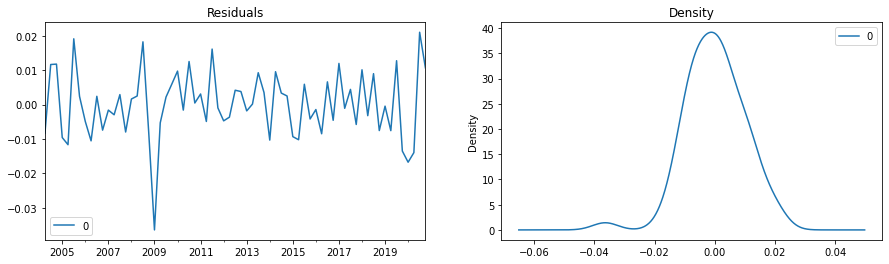

<Figure size 864x360 with 0 Axes>

In [61]:
# Plot residual errors
arima_residual_plots(modelfit)

In [62]:
#modelfit.plot_diagnostics()

### Rolling Prediction of growth rate 

In [63]:
pred_gdpGrowth = rolling_prediction(train, test, extra_test)

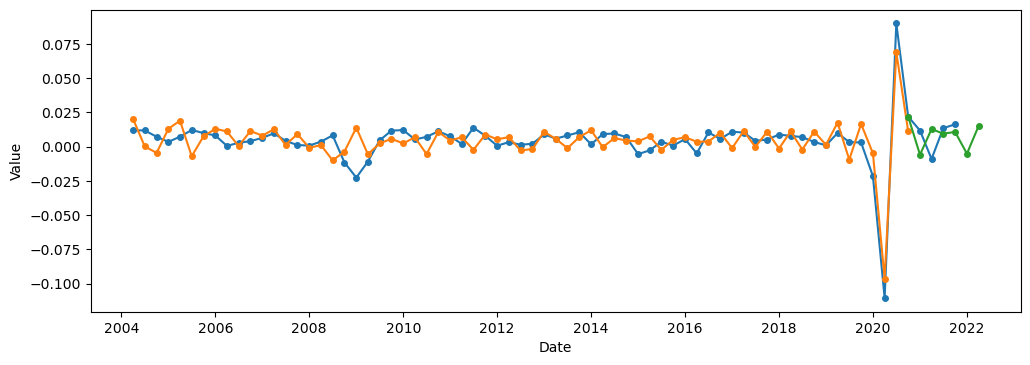

In [64]:
pred_gdpGrowth_for_plot = pd.concat([train['GDP_GrowthRate'].tail(1), pred_gdpGrowth])
fitted_values = pd.DataFrame({'GDP_GrowthRate': gdpts['GDP_GrowthRate'],
                              'Fitted Value': modelfit.predict(),
                              'Predicted Value': pred_gdpGrowth_for_plot.squeeze()})
plot_df(fitted_values, width=12, height=4)

### Rolling prediction of GDP value

Prediction error: 22214.934002415088


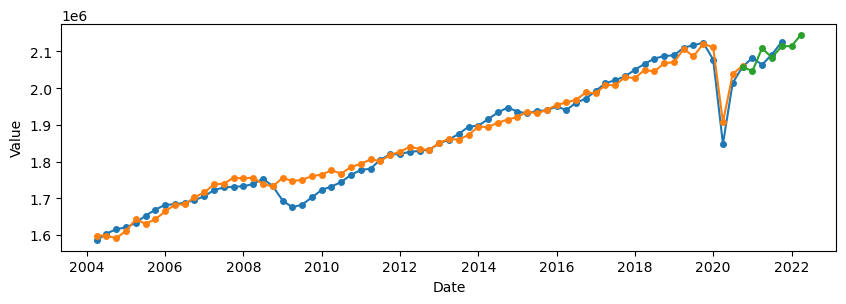

In [65]:
pred_error, fig, fitted_predicted_data = fitted_and_predicted_gdp(modelfit, pred_gdpGrowth, gdp_original, train, test, extra_test)
fig

In [66]:
fitted_predicted_data

,Actual GDP,Fitted GDP,Predicted GDP
2004-04-01,1585347.0,1.598343e+06,NaN
2004-07-01,1604061.0,1.598557e+06,NaN
2004-10-01,1615585.0,1.591201e+06,NaN
2005-01-01,1621176.0,1.611921e+06,NaN
2005-04-01,1632938.0,1.642384e+06,NaN
...,...,...,...
2021-04-01,2063554.0,NaN,2.108975e+06
2021-07-01,2091318.0,NaN,2.083064e+06
2021-10-01,2125350.0,NaN,2.113672e+06
2022-01-01,NaN,NaN,2.114423e+06


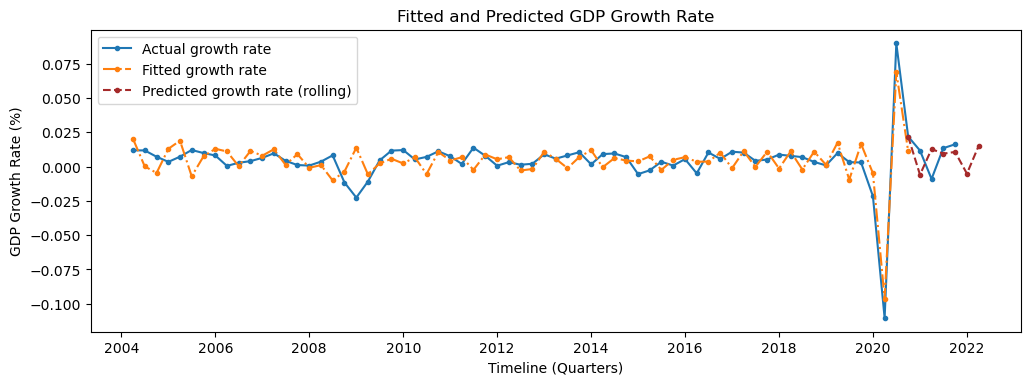

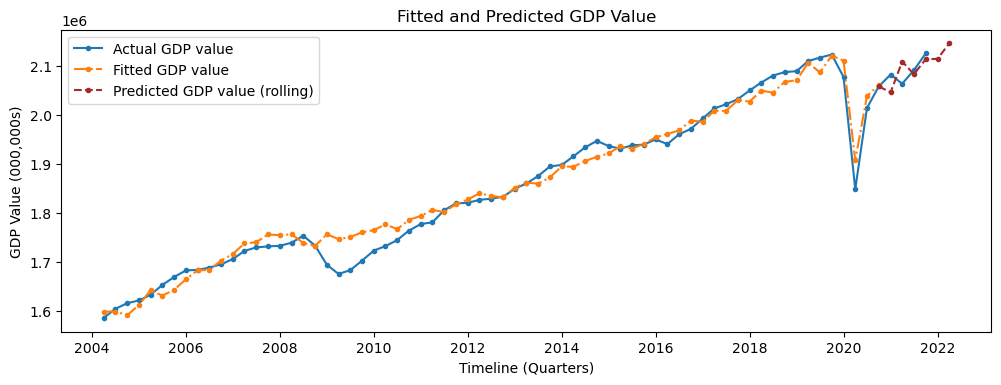

In [67]:
### Grwoth Rate and GDP value plots for presentation

#### Growth Rate plot
plot_data = fitted_values

plot_data.index = pd.to_datetime(plot_data.index)
fig1 = plt.figure(figsize=(12, 4), dpi=100)
plt.plot(plot_data.iloc[:,0], marker='o', markersize=3, label="Actual growth rate")
plt.plot(plot_data.iloc[:,1], marker='o', markersize=3, label="Fitted growth rate", linestyle="-.")
plt.plot(plot_data.iloc[:,2], marker='o', markersize=3, label="Predicted growth rate (rolling)", linestyle="--", color="brown")
plt.gca().set(title="Fitted and Predicted GDP Growth Rate",
              xlabel="Timeline (Quarters)", ylabel="GDP Growth Rate (%)")
plt.xticks()
plt.legend()
#plt.savefig('GDP_RrowthRate.png')
plt.show()


#### GDP Value
plot_data = fitted_predicted_data

plot_data.index = pd.to_datetime(plot_data.index)
fig2 = plt.figure(figsize=(12, 4), dpi=100)
plt.plot(plot_data.iloc[:,0], marker='o', markersize=3, label="Actual GDP value")
plt.plot(plot_data.iloc[:,1], marker='o', markersize=3, label="Fitted GDP value", linestyle="-.")
plt.plot(plot_data.iloc[:,2], marker='o', markersize=3, label="Predicted GDP value (rolling)", linestyle="--", color="brown")
plt.gca().set(title="Fitted and Predicted GDP Value",
              xlabel="Timeline (Quarters)", ylabel="GDP Value (000,000s)")
plt.xticks()
plt.legend()
#plt.savefig('GDP_value.png')
plt.show()

### Looping to select number of factors

### Bootstrap

In [68]:
from arch.bootstrap import optimal_block_length, CircularBlockBootstrap
from numpy.random import RandomState

In [79]:
# function to get the bootstrap samples
def get_bootstrap_samples(train_data, n_sample=100, rs=None):
    """ get circular and overlapping bootstrap samples """

    block_size = int(optimal_block_length(train_data).mean()[1])
    print("Block size: ", block_size)
    bs = CircularBlockBootstrap(block_size, train_data, random_state=rs)
    bs_data_lst = list()

    # create list of bootstrap samples
    for data in bs.bootstrap(n_sample):
        data[0][0].index = train_data.index
        bs_data_lst.append(data[0][0])
    return bs_data_lst


# function to plot prediction band for growth rate and also returns prediction band data
def growth_rate_plot_and_data_bs(predicted_growth_df=None,
                              lower_q = 0.025,
                              upper_q = 0.975,
                              modelfit= None, 
                              gdpts = None, 
                              train = None,
                              pred_gdpGrowth = None):

    pred_growth_rate_data = pd.DataFrame(columns=['Predicted GDP Growth Rate',
                                                  'Prediction interval (2.5%)',
                                                  'Prediction interval (97.5%)',
                                                  'Mean (Prediction interval)'])
    # calcualte quantiles
    quantiles = predicted_growth_df.quantile(q=[0.025, 0.975], axis=1, interpolation='linear')
    growth_quantiles = np.transpose(quantiles)

    pred_growth_rate_data['Predicted GDP Growth Rate'] = pred_gdpGrowth
    pred_growth_rate_data['Prediction interval (2.5%)'] = growth_quantiles[lower_q]
    pred_growth_rate_data['Prediction interval (97.5%)'] = growth_quantiles[upper_q]
    pred_growth_rate_data['Mean (Prediction interval)'] = predicted_growth_df.mean(axis=1)

    # organise data for plot
    pred_gdpGrowth_for_plot = pd.concat([train['GDP_GrowthRate'].tail(1), pred_gdpGrowth])
    fitted_values = pd.DataFrame({'GDP_GrowthRate': gdpts['GDP_GrowthRate'],
                                  'Fitted Value': modelfit.predict(),
                                  'Predicted Value': pred_gdpGrowth_for_plot.squeeze()})

    # plot
    fitted_values.index = pd.to_datetime(fitted_values.index)
    fig = plt.figure(figsize=(12, 4), dpi=100)
    plt.plot(fitted_values, marker='o', markersize=4)
    plt.plot(predicted_growth_df.mean(axis=1), color='green', linestyle='--')
    plt.fill_between(growth_quantiles.index, growth_quantiles[lower_q], growth_quantiles[upper_q], alpha = 0.2, color = 'green')
    plt.gca().set(title="", xlabel="", ylabel="")
    plt.close()
    return fig, pred_growth_rate_data

In [71]:
# create bootstrap samples
bs_samples = get_bootstrap_samples(train, n_sample=100, rs=None)  # RandomState(1234)

# get predicted growth rate uisng bootstrap samples
predicted_growth_df = pd.DataFrame(columns=list(range(0, len(bs_samples))))
for i, df in enumerate(bs_samples):
    predicted_growth_temp = rolling_prediction(df, test, extra_test, dependent_var='GDP_GrowthRate')
    predicted_growth_df.iloc[:, i] = predicted_growth_temp[0]


Block size:  9


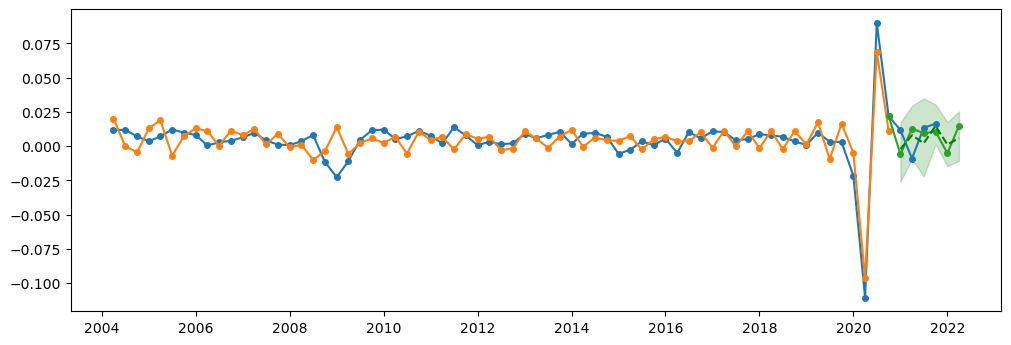

In [81]:
fig, data = growth_rate_plot_and_data_bs(predicted_growth_df=predicted_growth_df,
                              lower_q = 0.025,
                              upper_q = 0.975,
                              modelfit= modelfit, 
                              gdpts = gdpts, 
                              train = train,
                              pred_gdpGrowth = pred_gdpGrowth)
fig

In [82]:
data.tail()

,Predicted GDP Growth Rate,Prediction interval (2.5%),Prediction interval (97.5%),Mean (Prediction interval)
2021-04-01,0.012799,-0.009467,0.029459,0.008053
2021-07-01,0.009455,-0.021978,0.034835,0.002136
2021-10-01,0.010689,0.001382,0.030320,0.014726
2022-01-01,-0.005141,-0.014624,0.017460,0.001175
2022-04-01,0.014861,-0.010760,0.025282,0.005960


# Prediction interval for GDP value using bootstrap

In [83]:
# get predicted gdp value for bootstrap samples

predicted_gdp_df_bs = pd.DataFrame(columns=list(range(0, len(bs_samples))))
for i, df in enumerate(bs_samples):
    predicted_growth_rate_temp = predicted_growth_df[[i]].rename(columns={i: 0})
    _, _, gdp_data = fitted_and_predicted_gdp(modelfit, predicted_growth_rate_temp, gdp_original, train, test, extra_test)
    predicted_gdp_df_bs.iloc[:, i] = gdp_data['Predicted GDP'].dropna()

Prediction error: 19679.015986367096
Prediction error: 34817.0549049105
Prediction error: 41613.27902956514
Prediction error: 22869.98337222852
Prediction error: 22293.565611778744
Prediction error: 18001.56658680358
Prediction error: 14119.054384169838
Prediction error: 25182.57132614706
Prediction error: 13609.59634168976
Prediction error: 22465.3180603366
Prediction error: 35689.39364624413
Prediction error: 30577.810720123904
Prediction error: 22135.59445329008
Prediction error: 21111.84513144774
Prediction error: 22940.61742093441
Prediction error: 21534.486179631785
Prediction error: 20738.095004942385
Prediction error: 22744.282953413713
Prediction error: 36030.23130087398
Prediction error: 17946.046759797617
Prediction error: 24602.91611257016
Prediction error: 28214.146272732523
Prediction error: 24008.838691041583
Prediction error: 29779.6054796621
Prediction error: 19774.541006009807
Prediction error: 28489.600034883555
Prediction error: 19365.082766479078
Prediction error: 

In [89]:
def gdp_plot_and_data_bs(modelfit, pred_gdpGrowth, gdp_original, train, test, extra_test, predicted_gdp_df_bs, lower_q = 0.025, upper_q = 0.975):
    # fitted gdp value for training set
    base_GDP = gdp_original['GDP'][0]
    fitted_values = modelfit.predict()
    fitted_GDP = [0]*(len(fitted_values)+1)
    fitted_GDP[0] = base_GDP
    for i, value in enumerate(fitted_values):
        fitted_GDP[i+1] = fitted_GDP[i]*(1 + value)
    fitted_GDP_df = pd.DataFrame(fitted_GDP[1:])
    fitted_GDP_df.index = train.index

    # predicted gdp value for test set
    base_GDP_test = gdp_original[gdp_original.index == train.index[-1]]['GDP'][0]
    predicted_GDP = [0]*pred_gdpGrowth.shape[0]
    actual_GDP = base_GDP_test
    if not test.empty:
        for i in range(0, test.shape[0]):
            value = pred_gdpGrowth[0][i]
            predicted_GDP[i] = actual_GDP*(1 + value)
            actual_GDP = gdp_original.loc[test.index[i]][0]
        predicted_GDP_df = pd.DataFrame(predicted_GDP)
        predicted_GDP_df.index = pred_gdpGrowth.index
        predicted_GDP_df = pd.concat([gdp_original[gdp_original.index == train.index[-1]]['GDP'], predicted_GDP_df])

        # prediction error calculation
        org = gdp_original[gdp_original.index >= predicted_GDP_df.index[0]]
        error = 0
        for i in range(0, test.shape[0]):
            error = error + (org['GDP'][i]-predicted_GDP_df[0][i])**2
        pred_error = np.sqrt(error/predicted_GDP_df.shape[0])
        print(f"Prediction error: {pred_error}")

    # predicted gdp value for extra test set when test set is not empty
    if not extra_test.empty and not test.empty:
        base_GDP_test = gdp_original[gdp_original.index == test.index[-1]]['GDP'][0]
        actual_GDP = base_GDP_test
        for i in range(0, extra_test.shape[0]):
            value = pred_gdpGrowth.iloc[test.shape[0]+i][0]
            predicted_GDP[i] = actual_GDP*(1 + value)
            actual_GDP = predicted_GDP[i]
            predicted_GDP_df.iloc[test.shape[0]+i+1][0] = predicted_GDP[i]

    # predicted gdp value for extra test set when test set is empty
    if not extra_test.empty and test.empty:
        base_GDP_test = gdp_original[gdp_original.index == train.index[-1]]['GDP'][0]
        actual_GDP = base_GDP_test
        for i in range(0, extra_test.shape[0]):
            value = pred_gdpGrowth.iloc[i][0]
            predicted_GDP[i] = actual_GDP*(1 + value)
            actual_GDP = predicted_GDP[i]
        predicted_GDP_df = pd.DataFrame(predicted_GDP)
        predicted_GDP_df.index = pred_gdpGrowth.index
        predicted_GDP_df = pd.concat([gdp_original[gdp_original.index == train.index[-1]]['GDP'], predicted_GDP_df])
        pred_error = None

    pred_gdp_data = pd.DataFrame(columns=['GDP Value',
                                                  'Prediction interval (2.5%)',
                                                  'Prediction interval (97.5%)',
                                                  'Mean (Prediction interval)'])
    # calcualte quantiles
    quantiles = predicted_gdp_df_bs.quantile(q=[lower_q, upper_q], axis=1, interpolation='linear')
    value_quantiles = np.transpose(quantiles)

    pred_gdp_data['GDP Value'] = predicted_GDP_df[0][1:]
    pred_gdp_data['Prediction interval (2.5%)'] = value_quantiles[lower_q]
    pred_gdp_data['Prediction interval (97.5%)'] = value_quantiles[upper_q]
    pred_gdp_data['Mean (Prediction interval)'] = predicted_gdp_df_bs.mean(axis=1)

    Actual_GDP = gdp_original['GDP'][1:]
    fittedandActual_GDP = pd.DataFrame({'Actual GDP': Actual_GDP,
                                        'Fitted GDP': fitted_GDP_df.squeeze(),
                                        'Predicted GDP': predicted_GDP_df.squeeze()
                                       })

    # plot
    fittedandActual_GDP.index = pd.to_datetime(fittedandActual_GDP.index)
    fig = plt.figure(figsize=(12, 4), dpi=100)
    plt.plot(fittedandActual_GDP, marker='o', markersize=4)
    plt.plot(predicted_gdp_df_bs.mean(axis=1), color='green', linestyle='--')
    plt.fill_between(value_quantiles.index, value_quantiles[lower_q], value_quantiles[upper_q], alpha = 0.2, color = 'green')
    plt.gca().set(title="", xlabel="", ylabel="")
    plt.close()
    return fig, pred_gdp_data

Prediction error: 22214.934002415088


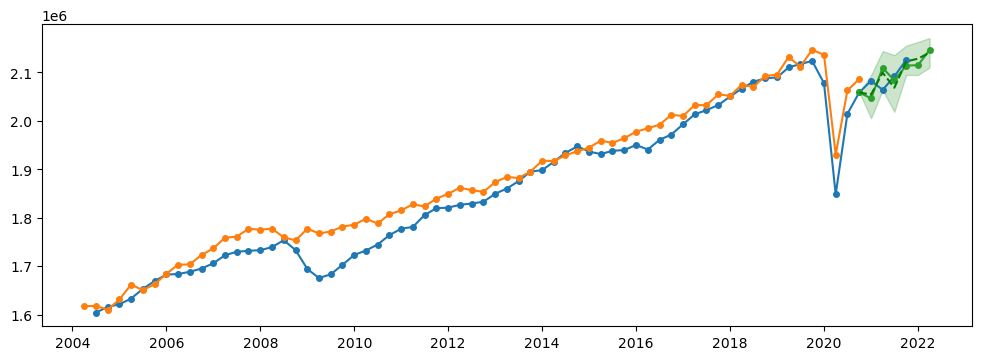

In [85]:
fig, pred_gdp_data = gdp_plot_and_data_bs(modelfit, pred_gdpGrowth, gdp_original, train, test, extra_test, predicted_gdp_df_bs, 
                                          lower_q = 0.025, upper_q = 0.975)
fig

In [86]:
pred_gdp_data

,GDP Value,Prediction interval (2.5%),Prediction interval (97.5%),Mean (Prediction interval)
2021-01-01,2.045946e+06,2.005069e+06,2.093820e+06,2.053913e+06
2021-04-01,2.108975e+06,2.062609e+06,2.143665e+06,2.099091e+06
2021-07-01,2.083064e+06,2.018201e+06,2.135438e+06,2.067962e+06
2021-10-01,2.113672e+06,2.094209e+06,2.154726e+06,2.122116e+06
2022-01-01,2.114423e+06,2.094269e+06,2.162458e+06,2.127847e+06
2022-04-01,2.145844e+06,2.109625e+06,2.170553e+06,2.140354e+06
